# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
#from sklearn.metrics import mean_squared_error

from lib import stepwise_selection

In [2]:
df = pd.read_csv('previsao_de_renda.csv').dropna().drop_duplicates()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('data_ref', axis=1, inplace=True)
df.drop('id_cliente', axis=1, inplace=True)

In [4]:
from dataclasses import replace


df = pd.get_dummies(df)
df.rename(lambda name: name.replace(' ', '_'), inplace=True, axis=1)
df['posse_de_veiculo'] = df['posse_de_veiculo'].astype('int')
df['posse_de_imovel'] = df['posse_de_imovel'].astype('int')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posse_de_veiculo               12427 non-null  int64  
 1   posse_de_imovel                12427 non-null  int64  
 2   qtd_filhos                     12427 non-null  int64  
 3   idade                          12427 non-null  int64  
 4   tempo_emprego                  12427 non-null  float64
 5   qt_pessoas_residencia          12427 non-null  float64
 6   renda                          12427 non-null  float64
 7   sexo_F                         12427 non-null  uint8  
 8   sexo_M                         12427 non-null  uint8  
 9   tipo_renda_Assalariado         12427 non-null  uint8  
 10  tipo_renda_Bolsista            12427 non-null  uint8  
 11  tipo_renda_Empresário          12427 non-null  uint8  
 12  tipo_renda_Pensionista         12427 non-null 

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

##### Parte 1

In [7]:
df_X = df.drop('renda', axis=1)
df_y = df['renda'].to_frame()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=.75)
df_train = pd.concat([X_train, y_train], axis=1)

##### Parte 2

In [30]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
        'sexo_M + posse_de_veiculo + posse_de_imovel + '
        'qtd_filhos + tipo_renda_Bolsista + tipo_renda_Empresário + '
        'tipo_renda_Pensionista + tipo_renda_Servidor_público + '
        'educacao_Primário + educacao_Pós_graduação + '
        'educacao_Superior_completo + educacao_Superior_incompleto + '
        'estado_civil_Separado + estado_civil_Solteiro + '
        'estado_civil_União + estado_civil_Viúvo +'
        'tipo_residencia_Aluguel + tipo_residencia_Com_os_pais + '
        'tipo_residencia_Comunitário + tipo_residencia_Estúdio + '
        'tipo_residencia_Governamental + idade + tempo_emprego + qt_pessoas_residencia',
        data = df_train
    )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=0, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)
    print(f'R²({alpha}) = {r_quadrado}')

R²(0) = 0.3914619299625272
R²(0.001) = 0.39027340299099766
R²(0.005) = 0.3763216854139829
R²(0.01) = 0.35085948880869594
R²(0.05) = 0.07247112226046577
R²(0.1) = 0.005277944083218187


Text(0, 0.5, 'R Quadrado')

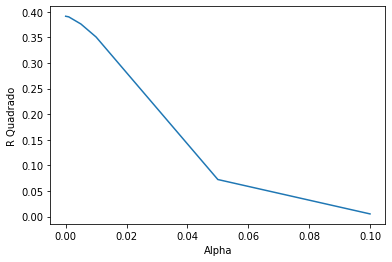

In [31]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Se considerarmos apenas o $R^2$, o melhor modelo é o de $\alpha = 0$.

##### Parte 3

In [32]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
        'sexo_M + posse_de_veiculo + posse_de_imovel + '
        'qtd_filhos + tipo_renda_Bolsista + tipo_renda_Empresário + '
        'tipo_renda_Pensionista + tipo_renda_Servidor_público + '
        'educacao_Primário + educacao_Pós_graduação + '
        'educacao_Superior_completo + educacao_Superior_incompleto + '
        'estado_civil_Separado + estado_civil_Solteiro + '
        'estado_civil_União + estado_civil_Viúvo +'
        'tipo_residencia_Aluguel + tipo_residencia_Com_os_pais + '
        'tipo_residencia_Comunitário + tipo_residencia_Estúdio + '
        'tipo_residencia_Governamental + idade + tempo_emprego + qt_pessoas_residencia',
        data = df_train
    )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)
    print(f'R²({alpha}) = {r_quadrado}')

R²(0) = 0.3914619299625274
R²(0.001) = 0.3904164690323379
R²(0.005) = 0.3990643772289674
R²(0.01) = 0.3990643772289674
R²(0.05) = 0.4063087146767544
R²(0.1) = 0.4063087146767544


Text(0, 0.5, 'R Quadrado')

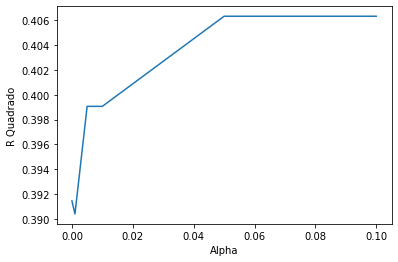

In [33]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Os melhores resultados foram $\alpha = 0.05$ e $\alpha = 0.1$

##### Parte 4

In [34]:
#X_stepwise = pd.get_dummies(X_train)
#y_stepwise = y_train
stepwise_selection(X_train, y_train)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_F                         with p-value 5.87144e-257
#############
['tempo_emprego', 'sexo_F']
Add  sexo_M                         with p-value 0.0
#############
['tempo_emprego', 'sexo_F', 'sexo_M']
Add  educacao_Superior_completo     with p-value 2.1818e-05
#############
['tempo_emprego', 'sexo_F', 'sexo_M', 'educacao_Superior_completo']
Add  idade                          with p-value 8.5971e-06
#############
['tempo_emprego', 'sexo_F', 'sexo_M', 'educacao_Superior_completo', 'idade']
Add  tipo_renda_Empresário          with p-value 0.000909259
#############
['tempo_emprego', 'sexo_F', 'sexo_M', 'educacao_Superior_completo', 'idade', 'tipo_renda_Empresário']
Add  posse_de_imovel                with p-value 0.0177945
#############
['tempo_emprego', 'sexo_F', 'sexo_M', 'educacao_Superior_completo', 'idade', 'tipo_renda_Empresário', 'posse_de_imovel']
Add  qt_pessoas_residencia          with p

['tempo_emprego',
 'sexo_F',
 'sexo_M',
 'educacao_Superior_completo',
 'idade',
 'tipo_renda_Empresário',
 'posse_de_imovel',
 'qt_pessoas_residencia']

In [35]:
reg = smf.ols('np.log(renda) ~ tempo_emprego + sexo_F + sexo_M + educacao_Superior_completo + idade + tipo_renda_Empresário + posse_de_imovel + qt_pessoas_residencia',
    data = df_train
).fit()
y_pred = np.exp(reg.predict(X_test))
y_real = y_test['renda']
r_quadrado = y_real.corr(y_pred) ** 2
print(f'R² = {r_quadrado}')

R² = 0.39826025683878197


O desempnho do algorítmo stepwise ficou próximo da melhor regularização.

##### Parte 5

O melhor modelo foi a regularização Lasso com $\alpha = 0.05$

##### Parte 6

In [36]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
            'sexo_M + posse_de_veiculo + posse_de_imovel + '
            'qtd_filhos + tipo_renda_Bolsista + tipo_renda_Empresário + '
            'tipo_renda_Pensionista + tipo_renda_Servidor_público + '
            'educacao_Primário + educacao_Pós_graduação + '
            'educacao_Superior_completo + educacao_Superior_incompleto + '
            'estado_civil_Separado + estado_civil_Solteiro + '
            'estado_civil_União + estado_civil_Viúvo +'
            'tipo_residencia_Aluguel + tipo_residencia_Com_os_pais + '
            'tipo_residencia_Comunitário + tipo_residencia_Estúdio + '
            'tipo_residencia_Governamental + idade + tempo_emprego + qt_pessoas_residencia',
            data = df_train
        )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=.5, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)
    print(f'R²({alpha}) = {r_quadrado}')

R²(0) = 0.3914619299625274
R²(0.001) = 0.3945021390387994
R²(0.005) = 0.40289904193951565
R²(0.01) = 0.4095401530745929
R²(0.05) = 0.39079085109820383
R²(0.1) = 0.3998788577917502


Text(0, 0.5, 'R Quadrado')

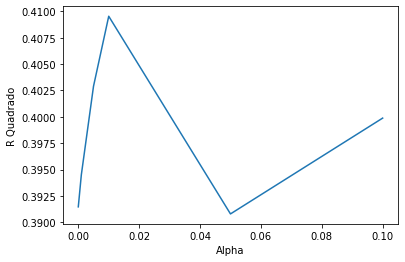

In [29]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Consegui um $R^2$ melhor com um $L_wt = 0.5$ e um $\alpha = 0.01$

##### Parte 7

In [37]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.42001478870465647

O $R^2$ com a árvore de regressão foi o melhor de todos.